In [1]:
import os
import gc
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:5


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

In [7]:
raw_train.columns

Index(['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'],
      dtype='object')

> ### Train-test-split

In [8]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [28]:
import matplotlib.gridspec as gridspec

In [33]:
def plot_feature(faultNumber, simulationRuns, feature):

#     data = raw_train[(raw_train['faultNumber'] == faultNumber) & (raw_train['simulationRun'] == simulationRun)]
    train_fault_start = 20
    
#     assert len(data) > 0, "No data!"

    plt.figure(figsize=(15, 1))
#     plt.plot(data[feature], '-go', markersize=2, label=feature)
    for sim_run in simulationRuns:
        data = raw_train[(raw_train['faultNumber'] == faultNumber) & (raw_train['simulationRun'] == sim_run)][feature]
        assert len(data) > 0, "No data!"
        
        y_data = data[:train_fault_start]
        x_data = np.arange(len(data[:train_fault_start]))
        
        plt.plot(x_data, y_data, '-o', c='yellowgreen', markersize=2)
        
        y_data = data[train_fault_start:]
        x_data = np.arange(train_fault_start, train_fault_start+len(data[train_fault_start:]))
        
        plt.plot(x_data, y_data, '-o', c='lightcoral', markersize=2)
    
    plt.vlines(x=train_fault_start, ymin=data.min(), ymax=data.max(), label='fault start')
    plt.legend(loc='upper right')
    plt.xlabel("i-th time step")
    plt.ylabel(f"{feature}")
    plt.show()

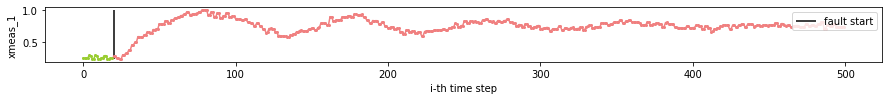

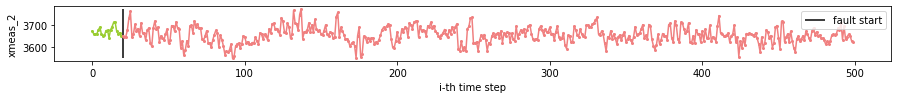

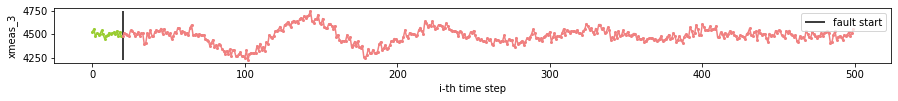

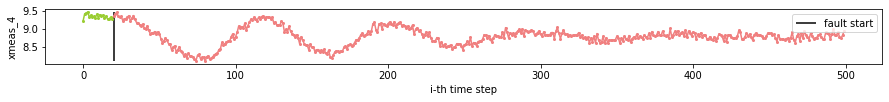

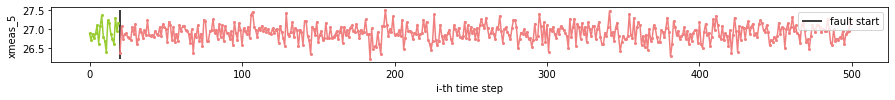

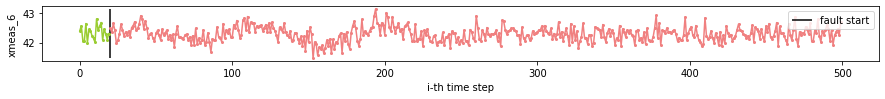

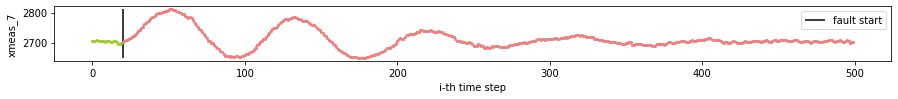

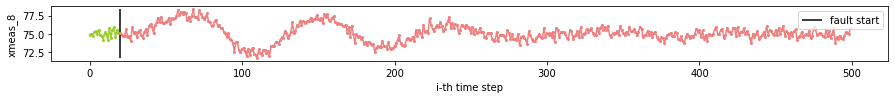

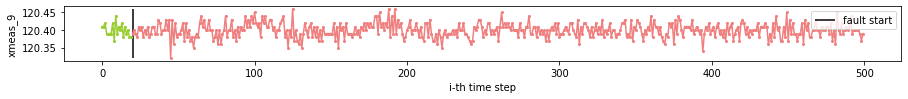

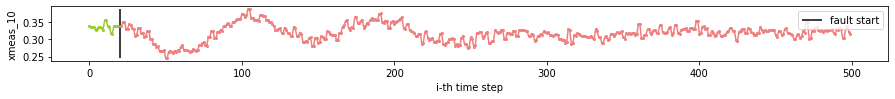

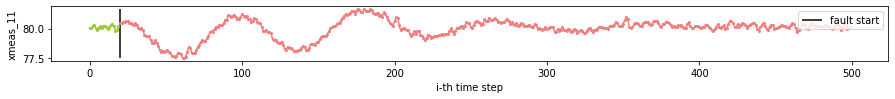

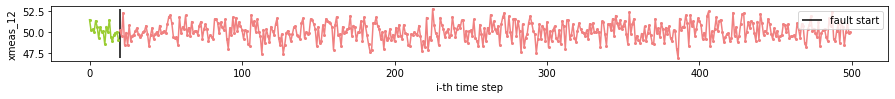

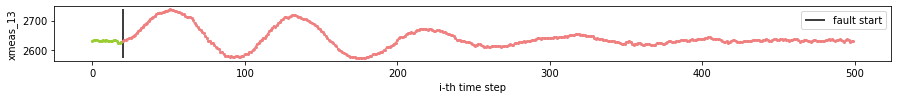

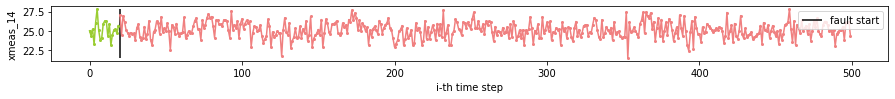

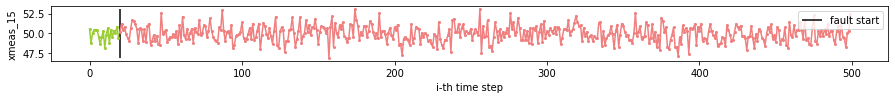

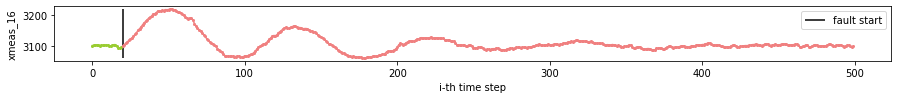

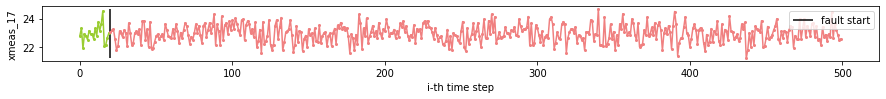

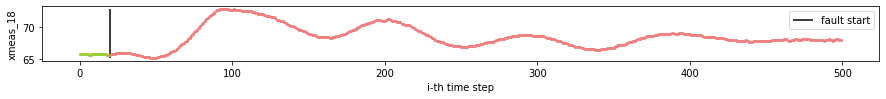

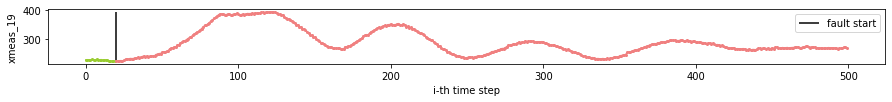

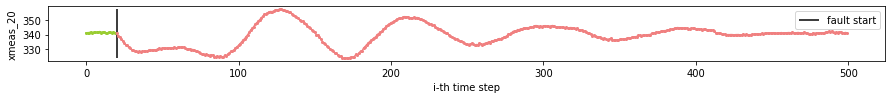

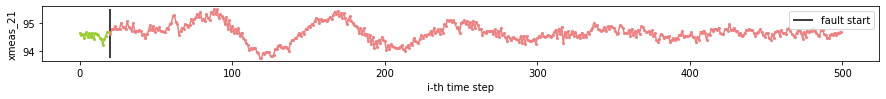

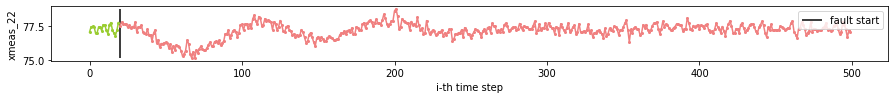

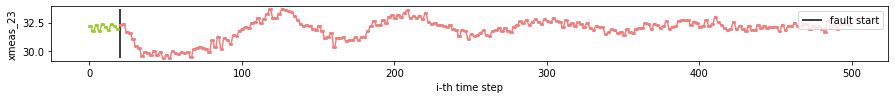

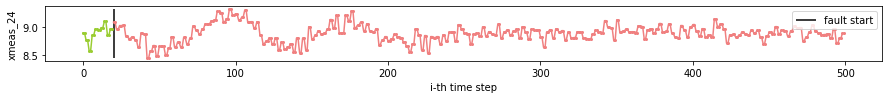

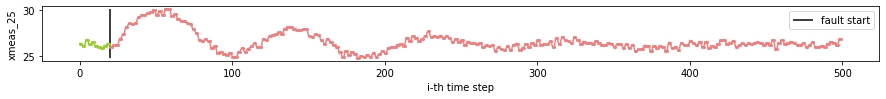

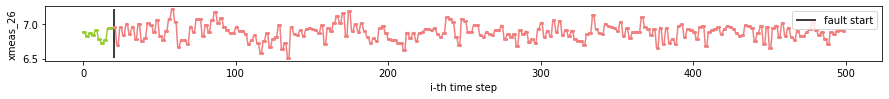

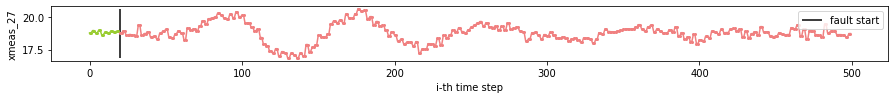

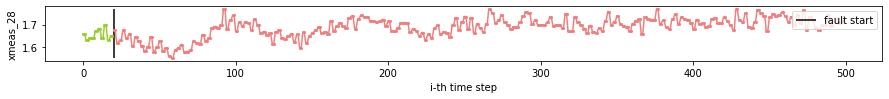

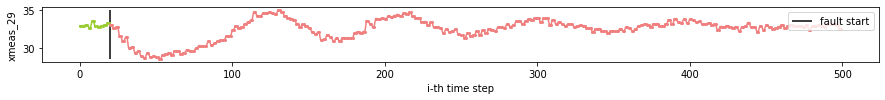

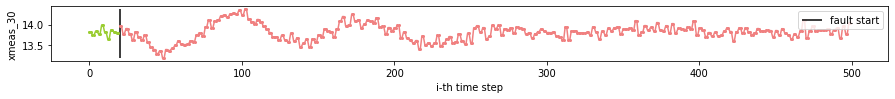

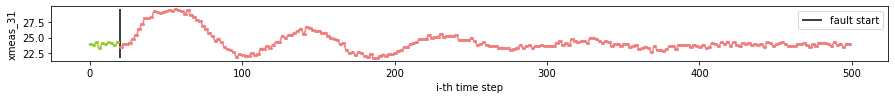

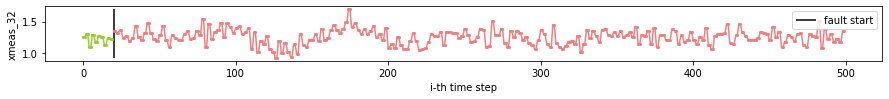

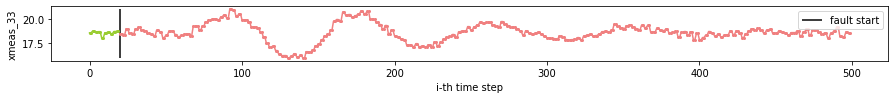

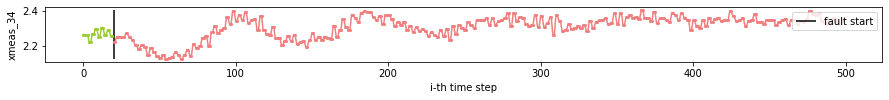

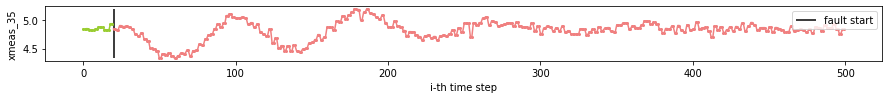

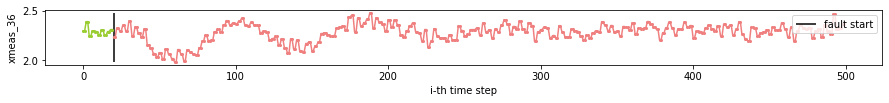

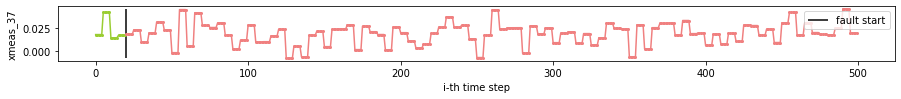

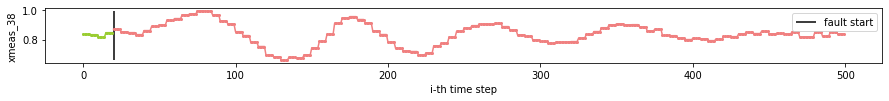

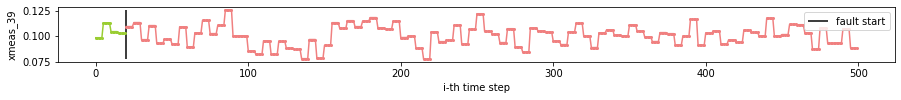

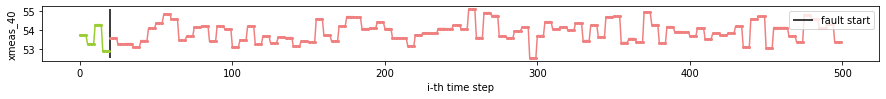

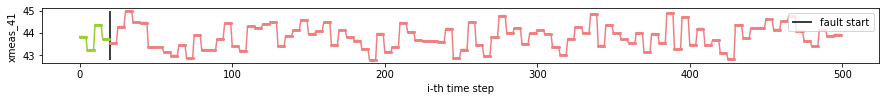

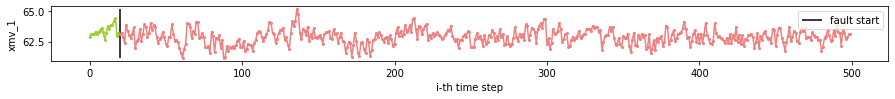

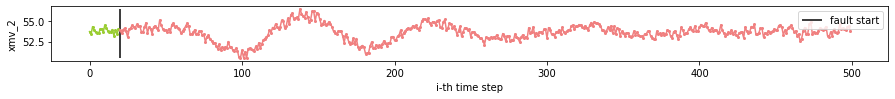

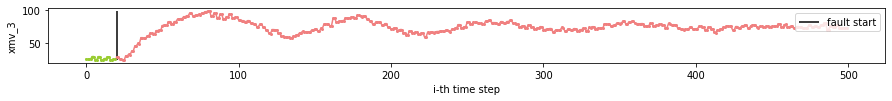

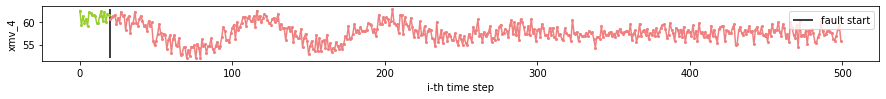

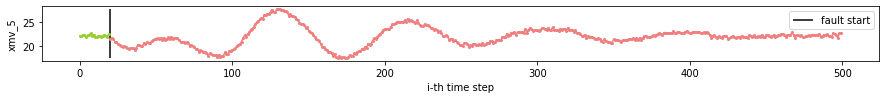

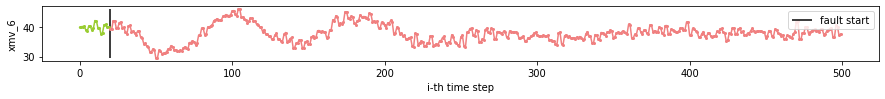

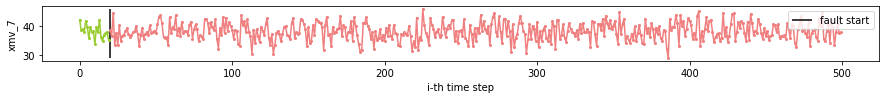

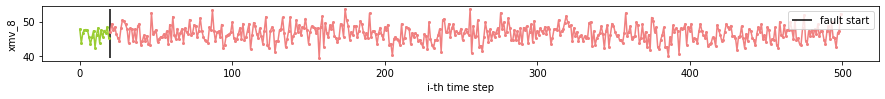

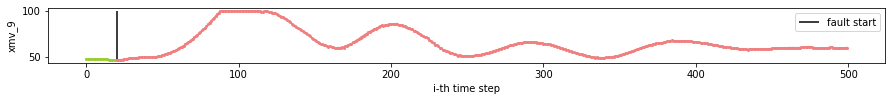

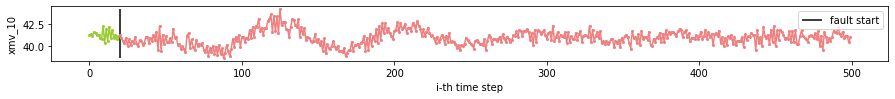

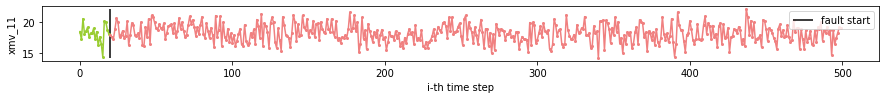

In [34]:
for feature in features:
#     plot_feature(faultNumber=0, simulationRuns=np.arange(1, 10), feature=feature)
    
    plot_feature(faultNumber=1, simulationRuns=[1], feature=feature)

In [150]:
def plotting(faultNumber, simulationRun, features):
    
    train_fault_start = 20    
    data = raw_train[(raw_train['faultNumber'] == faultNumber) & (raw_train['simulationRun'] == simulationRun)]
    
    fig, axes = plt.subplots(len(features), 1, figsize=(10, 10), gridspec_kw = {'wspace':0, 'hspace':0.2})
    axes = axes.flatten()

    for i, f in enumerate(features):
        
        y_before = data[:train_fault_start][f]
        x_before = np.arange(len(data[:train_fault_start]))
        
        y_after = data[train_fault_start:][f]
        x_after = np.arange(train_fault_start, train_fault_start+len(data[train_fault_start:]))
        
        axes[i].plot(x_before, y_before, '-o', c='yellowgreen', markersize=1)
        axes[i].plot(x_after, y_after, '-o', c='lightcoral', markersize=1)
        
        
#         print(np.min(y_before, y_after), max(y_before, y_after))
#         axes[i].axvline(train_fault_start, ymin=min(y_before.min(), y_after.min()), ymax=max(y_before.max(), y_after.max()))
        
        if i != len(features) - 1:
            axes[i].set_xticklabels([])
            
            
            
        
#         axes[i].set_aspect('equal')
        
#     plt.vlines(x=train_fault_start, ymin=data.min(), ymax=data.max(), label='fault start')
#     plt.legend(loc='upper right')
    plt.xlabel("i-th time step")
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.01, hspace=0.01)
#     plt.ylabel(f"{feature}")
    plt.show()

In [152]:
raw_train['faultNumber'].min()

0.0

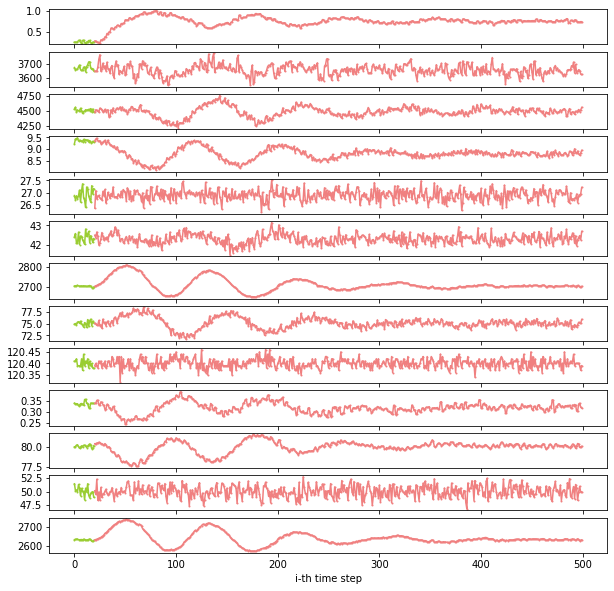

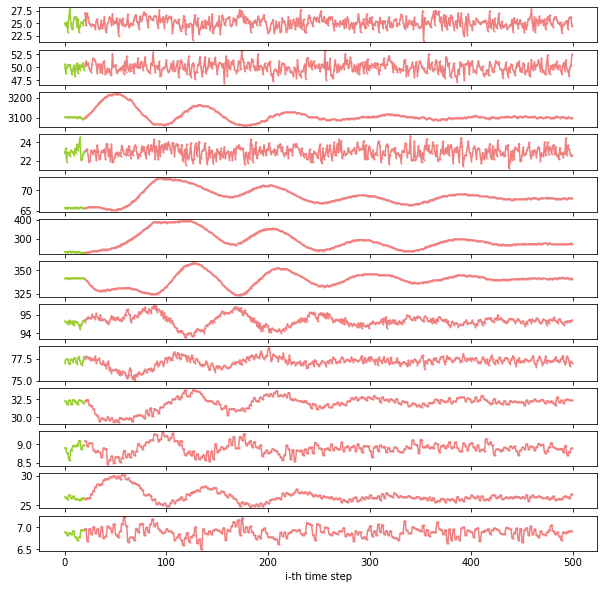

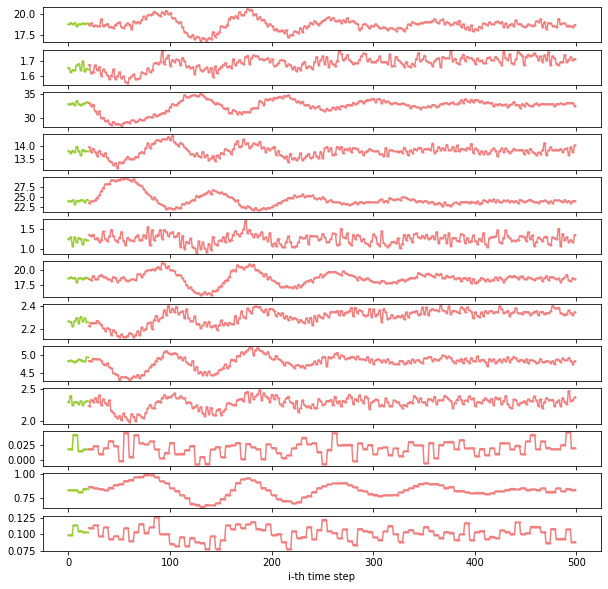

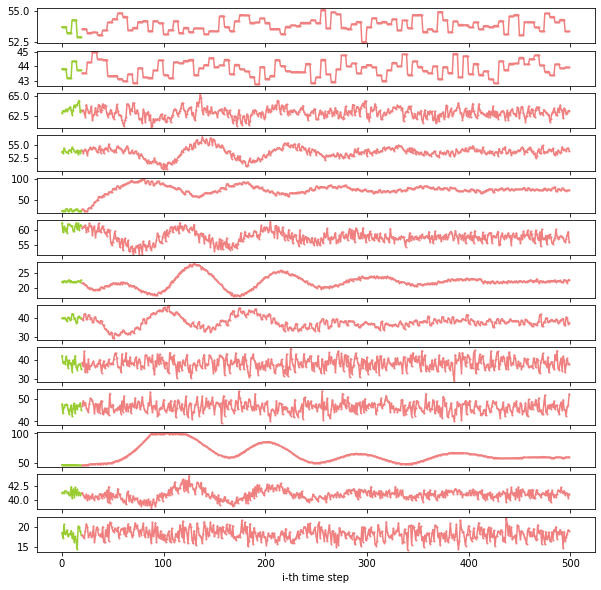

In [151]:
plotting(faultNumber=1, simulationRun=1, features=features[:13])
plotting(faultNumber=1, simulationRun=1, features=features[13:26])
plotting(faultNumber=1, simulationRun=1, features=features[26:39])
plotting(faultNumber=1, simulationRun=1, features=features[39:])